In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from quotient_manifold_tangent_vector_pytorch import QuotientManifoldTangentVector, riemannian_hess_quadratic_form, riemannian_power_method

In [2]:
N = 500
input_dim = 50
n_classes = 10
X = np.random.randn(N, input_dim)
y = np.random.binomial(n_classes-1, 0.5, size=(N,))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(50,30, bias=True)
        self.fc2 = nn.Linear(30,20, bias=True)
        self.fc3 = nn.Linear(20,10, bias=True)
        
    def get_weight_tensors(self):
        return [self.fc1.weight, self.fc2.weight, self.fc3.weight, self.fc1.bias, self.fc2.bias, self.fc3.bias]

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()

In [4]:
from torch.autograd import Variable
inputs, labels = Variable(torch.Tensor(X)), Variable(torch.Tensor(y).type(torch.LongTensor))

loss = criterion(net(inputs), labels)
print loss

tensor(2.3383, grad_fn=<NllLossBackward>)


In [5]:
alphas = [5.,4.,1./20.]
b_alphas = [5., 20., 1.]

t_alphas = alphas + b_alphas

W = [np.copy(var.data.numpy()) for var in net.get_weight_tensors()]
W_tr = [t_alphas[i]*W[i] for i in range(len(W))]

for i,var in enumerate(net.get_weight_tensors()):
    var.data.copy_(torch.Tensor(W_tr[i]))

tr_loss = criterion(net(inputs), labels)
print tr_loss

tensor(2.3383, grad_fn=<NllLossBackward>)


In [6]:
layer_sizes = [w.shape for w in W]
v_init = [np.random.normal(size=layer_sizes[i]) for i in range(len(layer_sizes))]

W_orig = QuotientManifoldTangentVector(layer_sizes)
W_orig.set_vector(W)
W_trans = QuotientManifoldTangentVector(layer_sizes)
W_trans.set_vector(W_tr)

In [7]:
for i,var in enumerate(net.get_weight_tensors()):
    var.data.copy_(torch.Tensor(W[i]))

v_res,errs = riemannian_power_method(v_init, 1000, net, criterion, W_orig, X, y, tol=1e-8)
sp_norm = riemannian_hess_quadratic_form(v_res, net, criterion, W_orig, X, y)
print sp_norm

2.391911960287674


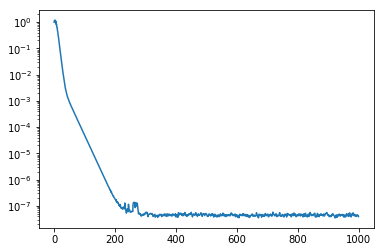

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(errs)

In [9]:
for i,var in enumerate(net.get_weight_tensors()):
    var.data.copy_(torch.Tensor(W_tr[i]))

v_res_tr, errs_tr = riemannian_power_method(v_init, 1000, net, criterion, W_trans, X, y, tol=1e-8)
sp_norm_tr = riemannian_hess_quadratic_form(v_res_tr, net, criterion, W_trans, X, y)
print sp_norm_tr

2.391912210901411


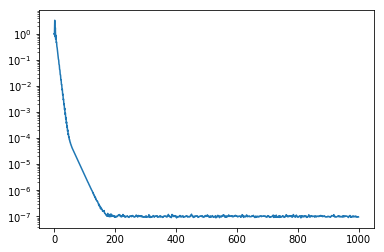

In [10]:
plt.semilogy(errs_tr)

In [11]:
print abs(sp_norm - sp_norm_tr)/sp_norm

1.047754854839771e-07


In [12]:
for i,var in enumerate(net.get_weight_tensors()):
    var.data.copy_(torch.Tensor(W[i]))

v_res_rep,errs_rep = riemannian_power_method(v_init, 1000, net, criterion, W_orig, X, y, tol=1e-8)
sp_norm_rep = riemannian_hess_quadratic_form(v_res, net, criterion, W_orig, X, y)
print sp_norm_rep

2.391911960287674


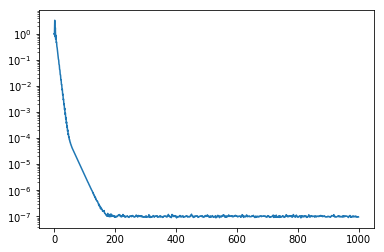

In [13]:
plt.semilogy(errs_tr)

In [14]:
print abs(sp_norm - sp_norm_rep)/sp_norm

0.0
